<a href="https://colab.research.google.com/github/heysourin/GNN-Graph-Neural-Network/blob/main/Paper/Convolutional_Graph_Neural_net_Paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q torch_geometric # for cora dataset

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import random
import os
import math
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch_geometric.datasets.karate import KarateClub
from torch_geometric.datasets import Planetoid #cora dataset
from torch_geometric.utils import to_dense_adj
import torch.nn.functional as F

import networkx as nx
from torch_geometric.utils import to_networkx
%matplotlib inline

Number of nodes in the graph 6
Number of edges in the graph 9

Adjacency Matrix shape (6, 6)
[[0 1 0 1 0 1]
 [1 0 1 1 1 0]
 [0 1 0 1 0 0]
 [1 1 1 0 0 1]
 [0 1 0 0 0 1]
 [1 0 0 1 1 0]]



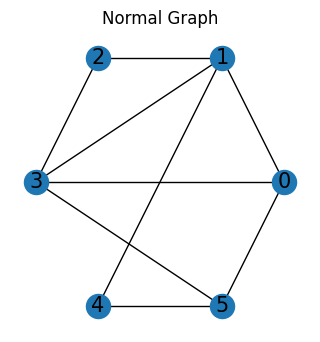

In [3]:
# adj = np.array([[0,1,0,1,0,1,1], [1,0,1,1,1,0,0], [0,1,0,1,0,1,0], [0,1,1,1,0,0,1], [0,1,1,0,0,0,1], [1,0,0,1,1,0,0], [1,0,0,1,1,0,1]]) # Testing Layer 1 o/p with 7*7 inputs

adj = np.array([[0,1,0,1,0,1], [1,0,1,1,1,0], [0,1,0,1,0,0], [1,1,1,0,0,1], [0,1,0,0,0,1], [1,0,0,1,1,0]])

G = nx.from_numpy_array(adj)
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print(f"Number of nodes in the graph {num_nodes}")
print(f"Number of edges in the graph {num_edges}")
print()

print(f"Adjacency Matrix shape {adj.shape}")
print(adj)
print()

# draw the graph using networkx
pos = nx.circular_layout(G)
plt.figure(figsize=(3, 3))
nx.draw(G, pos, with_labels=True, node_size=300, font_size=15, font_color='black')
plt.title("Normal Graph")
plt.show()

In [4]:
len(G)

6

In [5]:
adj

array([[0, 1, 0, 1, 0, 1],
       [1, 0, 1, 1, 1, 0],
       [0, 1, 0, 1, 0, 0],
       [1, 1, 1, 0, 0, 1],
       [0, 1, 0, 0, 0, 1],
       [1, 0, 0, 1, 1, 0]])

In [6]:
num_nodes

6

In [7]:
# create random features for each node having 3 dimensions
x = np.round(np.random.randn(num_nodes, 3), 2)
print(f"Feature Matrix shape {x.shape}")
print(x)

Feature Matrix shape (6, 3)
[[-0.73 -0.41  0.04]
 [ 1.19  1.54  1.18]
 [ 1.97 -0.65  1.46]
 [-0.66 -0.11  1.5 ]
 [-0.08  0.35  0.53]
 [-1.83 -0.18  1.42]]


In [8]:
x[1]

array([1.19, 1.54, 1.18])

In [9]:
adj @ x

array([[-1.3 ,  1.25,  4.1 ],
       [ 0.5 , -0.82,  3.53],
       [ 0.53,  1.43,  2.68],
       [ 0.6 ,  0.3 ,  4.1 ],
       [-0.64,  1.36,  2.6 ],
       [-1.47, -0.17,  2.07]])

In [10]:
# Message Passing
# This cell does similar to the above cell
for i in range(num_nodes):
  res = 0.
  print(f"Node {i} is connected to", end=' ')
  for n in G[i].keys():
    res += x[n]
    print(f"Node {n} {x[n]},", end=' ')

  print()
  print(f"Sum of connected neighbours {res}")
  print()

Node 0 is connected to Node 1 [1.19 1.54 1.18], Node 3 [-0.66 -0.11  1.5 ], Node 5 [-1.83 -0.18  1.42], 
Sum of connected neighbours [-1.3   1.25  4.1 ]

Node 1 is connected to Node 0 [-0.73 -0.41  0.04], Node 2 [ 1.97 -0.65  1.46], Node 3 [-0.66 -0.11  1.5 ], Node 4 [-0.08  0.35  0.53], 
Sum of connected neighbours [ 0.5  -0.82  3.53]

Node 2 is connected to Node 1 [1.19 1.54 1.18], Node 3 [-0.66 -0.11  1.5 ], 
Sum of connected neighbours [0.53 1.43 2.68]

Node 3 is connected to Node 0 [-0.73 -0.41  0.04], Node 1 [1.19 1.54 1.18], Node 2 [ 1.97 -0.65  1.46], Node 5 [-1.83 -0.18  1.42], 
Sum of connected neighbours [0.6 0.3 4.1]

Node 4 is connected to Node 1 [1.19 1.54 1.18], Node 5 [-1.83 -0.18  1.42], 
Sum of connected neighbours [-0.64  1.36  2.6 ]

Node 5 is connected to Node 0 [-0.73 -0.41  0.04], Node 3 [-0.66 -0.11  1.5 ], Node 4 [-0.08  0.35  0.53], 
Sum of connected neighbours [-1.47 -0.17  2.07]



In [11]:
G[1].keys()

KeysView(AtlasView({0: {'weight': 1}, 2: {'weight': 1}, 3: {'weight': 1}, 4: {'weight': 1}}))

[[1. 1. 0. 1. 0. 1.]
 [1. 1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 0. 1.]
 [0. 1. 0. 0. 1. 1.]
 [1. 0. 0. 1. 1. 1.]]


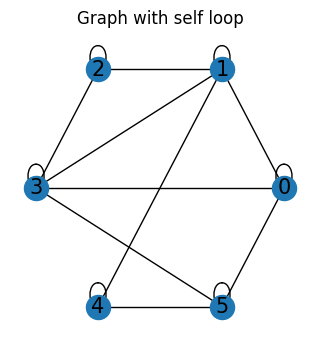

In [12]:
adj_loop = adj + np.eye(adj.shape[0]) #Just connecting node with itself
print(adj_loop)

# plotting
G_loop = nx.from_numpy_array(adj_loop)
pos = nx.circular_layout(G_loop)
plt.figure(figsize=(3, 3))
nx.draw(G_loop, pos, with_labels=True, node_size=300, font_size=15, font_color='black')
plt.title("Graph with self loop")
plt.show()

In [13]:
adj_loop @ x

array([[-2.03,  0.84,  4.14],
       [ 1.69,  0.72,  4.71],
       [ 2.5 ,  0.78,  4.14],
       [-0.06,  0.19,  5.6 ],
       [-0.72,  1.71,  3.13],
       [-3.3 , -0.35,  3.49]])

In [14]:
print("A tildde X = ")
print()

for i in range(num_nodes):
  res = 0.
  print(f"Node {i} is connected to", end=' ')
  for n in G_loop[i].keys():
    res += x[n]
    print(f"Node {n} {x[n]},", end=' ')

  print()
  print(f"Sum of connected neighbours {res}")
  print()

A tildde X = 

Node 0 is connected to Node 0 [-0.73 -0.41  0.04], Node 1 [1.19 1.54 1.18], Node 3 [-0.66 -0.11  1.5 ], Node 5 [-1.83 -0.18  1.42], 
Sum of connected neighbours [-2.03  0.84  4.14]

Node 1 is connected to Node 0 [-0.73 -0.41  0.04], Node 1 [1.19 1.54 1.18], Node 2 [ 1.97 -0.65  1.46], Node 3 [-0.66 -0.11  1.5 ], Node 4 [-0.08  0.35  0.53], 
Sum of connected neighbours [1.69 0.72 4.71]

Node 2 is connected to Node 1 [1.19 1.54 1.18], Node 2 [ 1.97 -0.65  1.46], Node 3 [-0.66 -0.11  1.5 ], 
Sum of connected neighbours [2.5  0.78 4.14]

Node 3 is connected to Node 0 [-0.73 -0.41  0.04], Node 1 [1.19 1.54 1.18], Node 2 [ 1.97 -0.65  1.46], Node 3 [-0.66 -0.11  1.5 ], Node 5 [-1.83 -0.18  1.42], 
Sum of connected neighbours [-0.06  0.19  5.6 ]

Node 4 is connected to Node 1 [1.19 1.54 1.18], Node 4 [-0.08  0.35  0.53], Node 5 [-1.83 -0.18  1.42], 
Sum of connected neighbours [-0.72  1.71  3.13]

Node 5 is connected to Node 0 [-0.73 -0.41  0.04], Node 3 [-0.66 -0.11  1.5 ], No

In [15]:
adj_loop # 'A' --> In paper

array([[1., 1., 0., 1., 0., 1.],
       [1., 1., 1., 1., 1., 0.],
       [0., 1., 1., 1., 0., 0.],
       [1., 1., 1., 1., 0., 1.],
       [0., 1., 0., 0., 1., 1.],
       [1., 0., 0., 1., 1., 1.]])

In [16]:
# Normalization --> simple one
D = np.sum(adj_loop, axis=1)
print(D)
print()
norm = np.diag(D ** -1) @ adj_loop
norm

[4. 5. 3. 5. 3. 4.]



array([[0.25      , 0.25      , 0.        , 0.25      , 0.        ,
        0.25      ],
       [0.2       , 0.2       , 0.2       , 0.2       , 0.2       ,
        0.        ],
       [0.        , 0.33333333, 0.33333333, 0.33333333, 0.        ,
        0.        ],
       [0.2       , 0.2       , 0.2       , 0.2       , 0.        ,
        0.2       ],
       [0.        , 0.33333333, 0.        , 0.        , 0.33333333,
        0.33333333],
       [0.25      , 0.        , 0.        , 0.25      , 0.25      ,
        0.25      ]])

In [17]:
D = np.sum(adj_loop, axis=1)
print(D)
print()
norm = np.diag(1/D) @ adj_loop
norm

[4. 5. 3. 5. 3. 4.]



array([[0.25      , 0.25      , 0.        , 0.25      , 0.        ,
        0.25      ],
       [0.2       , 0.2       , 0.2       , 0.2       , 0.2       ,
        0.        ],
       [0.        , 0.33333333, 0.33333333, 0.33333333, 0.        ,
        0.        ],
       [0.2       , 0.2       , 0.2       , 0.2       , 0.        ,
        0.2       ],
       [0.        , 0.33333333, 0.        , 0.        , 0.33333333,
        0.33333333],
       [0.25      , 0.        , 0.        , 0.25      , 0.25      ,
        0.25      ]])

In [18]:
D

array([4., 5., 3., 5., 3., 4.])

In [19]:
np.diag(1/D)

array([[0.25      , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.2       , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.33333333, 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.2       , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.33333333,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.25      ]])

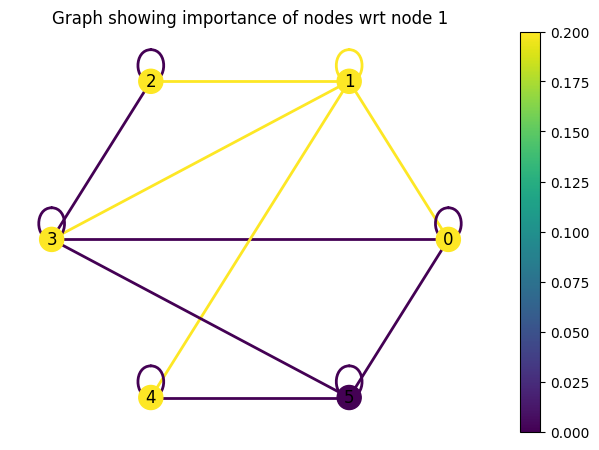

In [20]:
# PLOTTING FOR VISUALIZATION
# helper code to draw the graph showing node importance

# pick the node
node = 1

# get the normalized values as color
color_map = norm[node]

# set color to the edges
color_edges = []
for idx, i in enumerate(norm[node]):
    if i > 0.0:
        G_loop.edges[(node, idx)]['weight'] = i * 10
for k in G_loop.edges.keys():
    color_edges.append(G_loop.edges[k]['weight'])

# draw the graph
pos = nx.circular_layout(G_loop)
vmin = min(color_map)
vmax = max(color_map)
plt.figure(figsize=(6, 4))
nx.draw(G_loop, pos, node_color=color_map, width=2,
           with_labels=True, vmin=vmin, vmax=vmax, edge_color=color_edges)
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm, ax=plt.gca())
plt.title(f"Graph showing importance of nodes wrt node {node}")
plt.show()

In [21]:
# Better normalization: Acc to the paper --> Calling it renormalization
renorm = np.diag(D ** -0.5) @ adj_loop @ np.diag(D ** -0.5)
print("Symmetric Normalization using renormalization trick acc to the paper:")
print(renorm)
print()
print("Mean Normalization, ie the prev(sipler) one:")
print(norm)

Symmetric Normalization using renormalization trick acc to the paper:
[[0.25       0.2236068  0.         0.2236068  0.         0.25      ]
 [0.2236068  0.2        0.25819889 0.2        0.25819889 0.        ]
 [0.         0.25819889 0.33333333 0.25819889 0.         0.        ]
 [0.2236068  0.2        0.25819889 0.2        0.         0.2236068 ]
 [0.         0.25819889 0.         0.         0.33333333 0.28867513]
 [0.25       0.         0.         0.2236068  0.28867513 0.25      ]]

Mean Normalization, ie the prev(sipler) one:
[[0.25       0.25       0.         0.25       0.         0.25      ]
 [0.2        0.2        0.2        0.2        0.2        0.        ]
 [0.         0.33333333 0.33333333 0.33333333 0.         0.        ]
 [0.2        0.2        0.2        0.2        0.         0.2       ]
 [0.         0.33333333 0.         0.         0.33333333 0.33333333]
 [0.25       0.         0.         0.25       0.25       0.25      ]]


Graphs showing importance of node wrt node 1


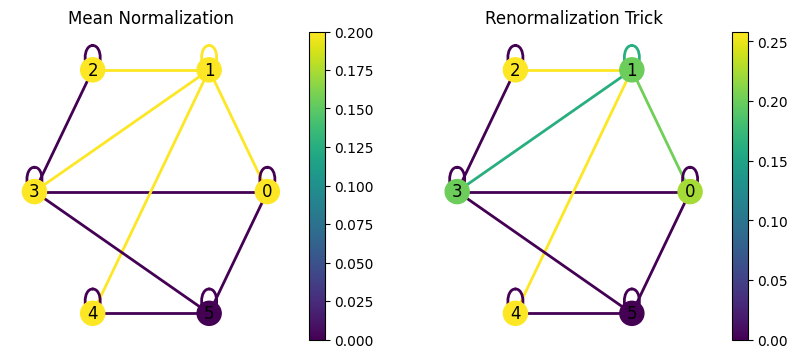

In [22]:
node = 1
print(f"Graphs showing importance of node wrt node {node}")
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
color_map = norm[node]
color_edges = []
for idx, i in enumerate(norm[node]):
    if i > 0.0:
        G_loop.edges[(node, idx)]['weight'] = i * 10
for k in G_loop.edges.keys():
    color_edges.append(G_loop.edges[k]['weight'])
pos = nx.circular_layout(G_loop)
vmin = min(color_map)
vmax = max(color_map)
nx.draw(G_loop, pos, node_color=color_map, width=2,
           with_labels=True, vmin=vmin, vmax=vmax, edge_color=color_edges)
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm, ax=plt.gca())
plt.title("Mean Normalization")

plt.subplot(1, 2, 2)
color_map = renorm[node]
color_edges = []
for idx, i in enumerate(renorm[node]):
    if i > 0.0:
        G_loop.edges[(node, idx)]['weight'] = i * 10
for k in G_loop.edges.keys():
    color_edges.append(G_loop.edges[k]['weight'])
pos = nx.circular_layout(G_loop)
vmin = min(color_map)
vmax = max(color_map)
nx.draw(G_loop, pos, node_color=color_map, width=2,
           with_labels=True, vmin=vmin, vmax=vmax, edge_color=color_edges)
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm, ax=plt.gca())
plt.title("Renormalization Trick")
plt.show()

In [23]:
# A * X
print("Message passing using unnormalized adjacency matrix")
print(adj @ x)
print()

# D^(-1/2) * A * D^(-1/2) * X
print("Message passing using normalized adjacency matrix")
print(renorm @ x)

Message passing using unnormalized adjacency matrix
[[-1.3   1.25  4.1 ]
 [ 0.5  -0.82  3.53]
 [ 0.53  1.43  2.68]
 [ 0.6   0.3   4.1 ]
 [-0.64  1.36  2.6 ]
 [-1.47 -0.17  2.07]]

Message passing using normalized adjacency matrix
[[-0.5214884   0.17225772  0.96426622]
 [ 0.43076294  0.11686155  1.05876006]
 [ 0.79351208  0.15255775  1.17863969]
 [ 0.04221841 -0.01375729  1.2394363 ]
 [-0.24768548  0.46233143  0.89126005]
 [-0.8106745  -0.07106045  0.85340802]]


---
## **GCN Layer:**

In [24]:
# Here we are defining 6 label for 6 nodes, to train our data

np.random.seed(2) # setting up the seed
print("Adjacency matrix shape :", adj_loop.shape)
print("Feature matrix shape: ", x.shape)

# create random labels for node classification task
y = np.random.randint(low=0, high=2, size=x.shape[0])
print("Labels", y)
print("Labels shape", y.shape)

Adjacency matrix shape : (6, 6)
Feature matrix shape:  (6, 3)
Labels [0 1 1 0 0 1]
Labels shape (6,)


In [25]:
# Converting all data to torch tensor
x = torch.tensor(x, dtype=torch.float)
y = torch.tensor(y, dtype=torch.long)
renorm = torch.tensor(renorm, dtype=torch.float32)

In [26]:
# Layer 1
fixed_generator = torch.Generator().manual_seed(4) # To keep the results reproducable
output_dim = 2 # we are choosing it
input_dim = x.shape[1] # x --> features. In this case x.shape = (6, 3)
# Ouput of Layer 1: (6, 2)

# weights
w1 = torch.randn(input_dim, output_dim, generator=fixed_generator) # D x W1
b1 = torch.randn(output_dim, generator=fixed_generator) # W1 x 1

# Some modifications of w and b acc to the paper
stdv = 1. / math.sqrt(w1.shape[1])
w1.uniform_(-stdv, stdv, generator=fixed_generator)
b1.uniform_(-stdv, stdv, generator=fixed_generator)

print(w1)
print(w1.shape)
print()
print(b1)
print(b1.shape)

tensor([[ 0.3726, -0.4049],
        [-0.2735, -0.6526],
        [ 0.0312, -0.2535]])
torch.Size([3, 2])

tensor([0.1519, 0.0329])
torch.Size([2])


In [27]:
message_agg = renorm @ x
z = message_agg @ w1 + b1
z = F.relu(z)
print("O/P of first layer: ")
print(z)
print(z.shape)

O/P of first layer: 
tensor([[0.0000, 0.0000],
        [0.3134, 0.0000],
        [0.4425, 0.0000],
        [0.2100, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.1912]])
torch.Size([6, 2])


In [29]:
# Layer 2
fixed_generator = torch.Generator().manual_seed(5) # To keep the results reproducable
output_dim = 2 # we are choosing it
input_dim = z.shape[1] # outputs of prev layer

# weights
w2 = torch.randn(input_dim, output_dim, generator=fixed_generator) # D x W1
b2 = torch.randn(output_dim, generator=fixed_generator) # W1 x 1

# Some modifications of w and b acc to the paper
stdv = 1. / math.sqrt(w2.shape[1])
w2.uniform_(-stdv, stdv, generator=fixed_generator)
b2.uniform_(-stdv, stdv, generator=fixed_generator)

print(w2)
print(w2.shape)
print()
print(b2)
print(b2.shape)

tensor([[-0.6047,  0.2253],
        [ 0.3041,  0.1122]])
torch.Size([2, 2])

tensor([0.6801, 0.2124])
torch.Size([2])


In [30]:
# Layer 2 forward pass
message_agg_2 = renorm @ z
out = message_agg_2 @ w2 + b2

print("O/P of second layer: ")
print(out)
print(out.shape)

O/P of second layer: 
tensor([[0.6239, 0.2441],
        [0.5477, 0.2617],
        [0.5092, 0.2760],
        [0.5607, 0.2665],
        [0.6480, 0.2368],
        [0.6663, 0.2283]])
torch.Size([6, 2])


In [33]:
# Applying softmax
loss = F.cross_entropy(out, y)
print(loss)

tensor(0.6976)


In [ ]:
class GCNLayer(nn.Module):
  def __init__(self, in_feat, out_feat):
    super().__init__()
    self.in_feat = in_feat
    self.out_feat = out_feat

    self.projection = nn.Linear(in_feat, out_feat)

  def forward(self, x, A_norm):
    x = torch.mm(A_norm, x)
    x = self.projection(x)
    return x

  def __repr__(self):
    return f"GCNLayer ({self.in_feat} -> {self.out_feat})"

class GCNModel(nn.Module):
  def __init__(self, in_feat, num_hidden, nclass, dropout=None):
    super().__init__()

    # layer initialization
    self.gcn_l1 = GCNLayer(in_feat, num_hidden)
    self.gcn_l2 = GCNLayer(num_hidden, nclass)

    self.dropout = dropout

  def forward(self, x, A_norm):
    x = self.actn(self.gcn_l1(x, A_norm))
    if self.dropout is not None:
      x = F.dropout(x, p=self.dropout, training=self.training)
    x = self.gcn_l2(x, A_norm)
    return x

----
### **My exps for the sake of science :D**

In [28]:
# My exp: Just checking how can (6, 2) be added with (2,) bias

import torch

# Suppose message_agg @ w1 is a tensor of shape (6, 2)
message_agg_w1 = torch.tensor([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0], [7.0, 8.0], [9.0, 10.0], [11.0, 12.0]])

# Suppose b1 is a tensor of shape (2,)
b1 = torch.tensor([0.5, 1.5])

# Adding them together
result = message_agg_w1 + b1
print(result)


tensor([[ 1.5000,  3.5000],
        [ 3.5000,  5.5000],
        [ 5.5000,  7.5000],
        [ 7.5000,  9.5000],
        [ 9.5000, 11.5000],
        [11.5000, 13.5000]])
